# Finetune

Finetune base encoder on downstream tasks.

In [1]:
!nvidia-smi

Sat Jan 15 21:55:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   31C    P0    40W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.cuda.empty_cache()

try:
    del full_train_dataset
except:
    pass
try:
    del full_validation_dataset
except:
    pass
try:
    del full_test_dataset
except:
    pass

import gc
gc.collect()

0

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datasets import load_metric
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, AutoModel
from datasets import Dataset, DatasetDict, ClassLabel, load_metric
from sklearn.model_selection import train_test_split

import matplotlib

FONTSIZE = 30
matplotlib.rc('font', size=FONTSIZE)
matplotlib.rc('axes', titlesize=FONTSIZE)


def quantize_feature(values, edges):
    labels = values.copy().astype(np.int)
    for i, _edge in enumerate(edges[:-1]):
        if i == 0:
            mask = values < edges[i+1]
        else:
            mask = np.logical_and(values >= edges[i], values < edges[i+1])
        labels[mask] = i
    return labels


def plot_confusion(predictions, true_vals, normalize=True):
    cf_matrix = confusion_matrix(true_vals, predictions, normalize="true" if normalize else None)
    fig, ax = plt.subplots(figsize=(8, 5)) 
    sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='.2g', vmin=0, vmax=1);
    ax.set_ylabel("GROUND TRUTH")
    ax.set_xlabel("PREDICTION");


def histedges_equalN(x, nbin, max_val=None):
    # https://stackoverflow.com/a/39419049
    npt = len(x)
    edges = np.interp(np.linspace(0, npt, nbin + 1), np.arange(npt), np.sort(x))
    if max_val:
        edges[-1] = max_val
    return edges


def create_datasets(tokenized_lyrics, feature, n=None, verbose=True, n_class=1, max_val=1):
    """
    n_class : if provided, quantize to this many classes with equal amount of per class
    n : to subset for testing purposes
    """
    lyrics_lab = tokenized_lyrics.copy()
    
    if feature == "genre":
        # already multiclass so different preparation
        labels_lst = sorted(list(set(df_clean["genre"])))
        labels = ClassLabel(names=labels_lst)
        lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", labels.str2int(train["genre"]))
        lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", labels.str2int(val["genre"]))
        lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", labels.str2int(test["genre"]))

        # cast to ClassLabel
        for _key in lyrics_lab.keys():
            new_features = lyrics_lab[_key].features.copy()
            new_features["labels"] = labels
            lyrics_lab[_key] = lyrics_lab[_key].cast(new_features)
            
    else:
    
        if n_class > 1:
            edges = histedges_equalN(train[feature].values, n_class, max_val=max_val)
            if verbose:
                print(edges)
            lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", quantize_feature(train[feature], edges))
            lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", quantize_feature(val[feature], edges))
            lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", quantize_feature(test[feature], edges))
        else:
            lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", train[feature])
            lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", val[feature])
            lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", test[feature])
            
    if verbose:
        print(lyrics_lab)
    
    if n is not None:
        lyrics_lab["train"] = lyrics_lab["train"].shuffle(seed=seed).select(range(n)) 
        lyrics_lab["validation"] = lyrics_lab["validation"].shuffle(seed=seed).select(range(n)) 
        lyrics_lab["test"] = lyrics_lab["test"].shuffle(seed=seed).select(range(n)) 
    
    if verbose:
        print(lyrics_lab["train"])
        print(lyrics_lab["validation"])
        print(lyrics_lab["test"])
            
    return lyrics_lab


def create_trainer(
    model_str,
    lyrics, 
    freeze_base_model, 
    feature, 
    batch_size, 
    n_epochs, 
    n_class=1,
    learning_rate=None, 
    n=None,
    verbose=True,
    max_val=1,
    output_dir=None,
    remove_classification_head=False
):
    """
    lyrics : DatasetDict object with "train", "validation", and "test" keys
    n_class : if provided, quantize to this many classes with equal amount of per class
    n : to subset for testing purposes
    """
    
    # tokenize lyrics
    tokenizer = AutoTokenizer.from_pretrained(model_str, use_fast=True)
    if model_str == "gpt2":
        tokenizer.pad_token = tokenizer.eos_token
    def preprocess_function(examples):
        return tokenizer(examples["text"], padding=True, truncation=True)
    tokenized_lyrics = lyrics.map(preprocess_function, batched=True)
    if verbose:
        print("tokenized lyrics", tokenized_lyrics)
    
    # label train, validation, test sets
    lyrics_lab = create_datasets(tokenized_lyrics, feature, n, verbose, n_class, max_val)
    if feature == "genre":
        # already multiclass so different preparation
        labels_lst = sorted(list(set(df_clean["genre"])))
        n_class = len(labels_lst)

    # create model
    if remove_classification_head:
        # if finetuning on different task
        model = AutoModel.from_pretrained(model_str, num_labels=n_class)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(model_str, num_labels=n_class)
    if freeze_base_model:
        for name, param in model.named_parameters():
            if 'classifier' not in name: # classifier layer
                param.requires_grad = False
        if learning_rate is None:
            learning_rate = 2e-3
    else:
        if learning_rate is None:
            learning_rate = 2e-5
        for name, param in model.named_parameters():
            param.requires_grad = True
            
    # set up training
    if output_dir is None:
        
        if os.path.isdir(model_str):
            output_dir = model_str.replace("/", "-")
            if not freeze_base_model:
                output_dir = output_dir.replace("_frozen", "_unfrozen")
        else:
            output_dir = f"{os.path.basename(model_str)}-finetuned-{feature}"
            if n_class > 1 and feature != "genre":
                output_dir += f"_quant{n_class}"
            if freeze_base_model:
                output_dir += "_frozen_base"
            if n:
                output_dir += f"_TEST{n}"
    if verbose:
        print(learning_rate)
        print(output_dir)
    training_args = TrainingArguments(
        output_dir, 
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=n_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy" if n_class > 1 else None,
    )
    
    if n_class > 1:
        metric = load_metric("accuracy")
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            return metric.compute(predictions=predictions, references=labels)
    else:
        compute_metrics = None

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=lyrics_lab["train"],
        eval_dataset=lyrics_lab["validation"],
        tokenizer=AutoTokenizer.from_pretrained(model_str, use_fast=True),
        compute_metrics=compute_metrics
    )
    
    return trainer, lyrics_lab["train"], lyrics_lab["validation"], lyrics_lab["test"]



df_clean = pd.read_pickle('df_clean_v4_14122021_py35.pkl')
print(df_clean.shape)
df_clean.head()

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


(15863, 17)


,lyrics,explicit,song_name,song_popularity,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,release_year,artist,genre
song_id,,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,"thank u, next",86,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,2019,Ariana Grande,dance pop
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,Without Me,87,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,2018,Halsey,dance pop
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,SICKO MODE,85,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,2018,Travis Scott,hip-hop/rap
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,High Hopes,86,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,2018,Panic! At The Disco,rock
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,All I Want for Christmas Is You,63,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277,1994,Mariah Carey,dance pop


In [4]:
df_clean["genre"].value_counts()

rock             3476
pop              2774
country          2412
soul/disco       2339
dance pop        2082
hip-hop/rap      1472
r&b               972
acoustic/folk     336
Name: genre, dtype: int64

fine-tuning tasks: https://ruder.io/recent-advances-lm-fine-tuning/
"The pre-trained model is then fine-tuned on labelled data of a downstream task using a standard cross-entropy loss."

Hugging Face examples: https://huggingface.co/docs/transformers/training

IMDB downstream task example: https://colab.research.google.com/github/huggingface/notebooks/blob/master/transformers_doc/custom_datasets.ipynb#scrollTo=B0WiFsYNDhbs

# 1) split dataset

In [5]:
seed = 11
val_size = 0.15
test_size = 0.15
train, _eval = train_test_split(
    df_clean, test_size=val_size + test_size, random_state=seed, stratify=df_clean['genre']
)
val, test = train_test_split(
    _eval, test_size=test_size / (val_size + test_size), random_state=seed, stratify=_eval['genre']
)

# # wrong spliting from before
# seed = 11
# val_size = 0.15
# test_size = 0.15
# train, _eval = train_test_split(df_clean, test_size=val_size + test_size, random_state=seed)
# val, test = train_test_split(df_clean, test_size=test_size / (val_size + test_size), random_state=seed)

print(train.shape)
print(val.shape)
print(test.shape)

(11104, 17)
(2379, 17)
(2380, 17)


In [6]:
lyrics = DatasetDict()

# arguments expected by forward: https://github.com/huggingface/transformers/blob/9aeacb58bab321bc21c24bbdf7a24efdccb1d426/src/transformers/modeling_bert.py#L1313
lyrics["train"] = Dataset.from_dict({"text": list(train["lyrics"])})
lyrics["validation"] = Dataset.from_dict({"text": list(val["lyrics"])})
lyrics["test"] = Dataset.from_dict({"text": list(test["lyrics"])})

print(lyrics)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2380
    })
})


# 2) genre classification

In [ ]:
""" select model """
# different models for sentence modeling: https://www.sbert.net/docs/pretrained_models.html
# model_str = "gpt2"
# model_str = "bert-base-cased"
# model_str = "distilbert-base-uncased"
model_str = "sentence-transformers/all-mpnet-base-v2"    # 418 MB, 384 max length
# model_str = "sentence-transformers/all-distilroberta-v1"   # 292 MB, 512 max length
# model_str = "sentence-transformers/all-MiniLM-L6-v2"       # 80 MB, 256 max length
# model_str = "sentence-transformers/all-MiniLM-L12-v2"       # 118 MB, 256 max length

In [42]:
trainer_genre, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str,
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature="genre", 
    batch_size=32, 
    n_epochs=5,
    verbose=True,
#     n=500
)

loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})


Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})


loading configuration file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/config.json from cache at /home/vidit/.cache/huggingface/transformers/713edf97a7faf69710cdf8941156f76a463a5280c7f1ae8a52981c275fcb590d.7aca2223c920d6c0c35d97cd3441414b9cd4cdddaf013b3e9ed88247815781f3
Model config MPNetConfig {
  "_name_or_path": "microsoft/mpnet-base",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps":

0.002
all-mpnet-base-v2-finetuned-genre_frozen_base


loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

In [40]:
# # check data
# len(trainer_genre.train_dataset[0]["attention_mask"]) == len(trainer_genre.train_dataset[0]["input_ids"])
# print(trainer_genre.train_dataset[0]["labels"])
# print(trainer_genre.train_dataset.features["labels"].names)

In [43]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer_genre.train()

# # https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.train.resume_from_checkpoint
# trainer_genre.train(resume_from_checkpoint=True)

Loading model from all-mpnet-base-v2-finetuned-genre_frozen_base/checkpoint-1041).
The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 3
  Continuing training from global step 1041
  Will skip the first 3 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy
4,1.576300,1.561846,0.425809
5,1.554000,1.556660,0.432955


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-mpnet-base-v2-finetuned-genre_frozen_base/checkpoint-1388
Configuration saved in all-mpnet-base-v2-finetuned-genre_frozen_base/checkpoint-1388/config.json
Model weights saved in all-mpnet-base-v2-finetuned-genre_frozen_base/checkpoint-1388/pytorch_model.bin
tokenizer config file saved in all-mpnet-base-v2-finetuned-genre_frozen_base/checkpoint-1388/tokenizer_config.json
Special tokens file saved in all-mpnet-base-v2-finetuned-genre_frozen_base/checkpoint-1388/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-

TrainOutput(global_step=1735, training_loss=0.6192646125551603, metrics={'train_runtime': 331.8727, 'train_samples_per_second': 167.293, 'train_steps_per_second': 5.228, 'total_flos': 1.460871274561536e+16, 'train_loss': 0.6192646125551603, 'epoch': 5.0})

In [44]:
h = trainer_genre.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


['0 - acoustic/folk', '1 - country', '2 - dance pop', '3 - hip-hop/rap', '4 - pop', '5 - r&b', '6 - rock', '7 - soul/disco']


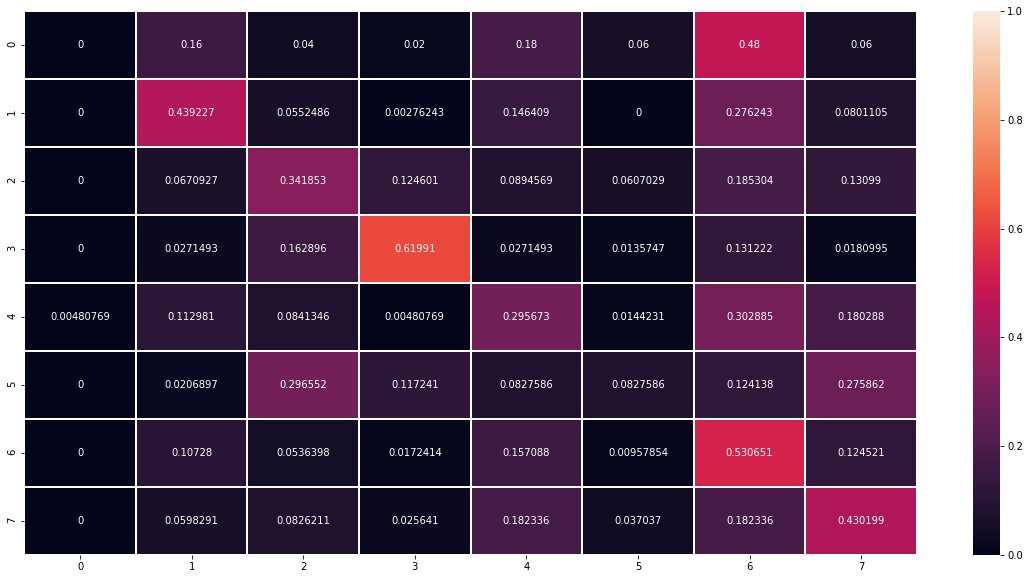

In [45]:
normalize = True


labels = trainer_genre.train_dataset.features["labels"]
predictions = np.argmax(h.predictions, axis=-1)
true_vals = h.label_ids
cf_matrix = confusion_matrix(true_vals, predictions, normalize="true" if normalize else None)
fig, ax = plt.subplots(figsize=(20,10)) 
if normalize:
    sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g', vmin=0, vmax=1)
else:
    sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
print([f"{i} - {lab}" for i, lab in enumerate(labels.names)])

## fine-tune from checkpoint with base model unfrozen


In [7]:
# finetune from local model
trainer_genre, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="all-mpnet-base-v2-finetuned-genre_frozen_base/checkpoint-1735",
#     model_str="all-distilroberta-v1-finetuned-genre_frozen_base/checkpoint-1735",
    learning_rate=2e-5,
    lyrics=lyrics, 
    freeze_base_model=False, 
    feature="genre", 
    batch_size=32, 
    n_epochs=8,
    verbose=True,
#     n=500
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})


Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})
0.002
all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735


In [15]:
# # check that gradient tracked
# for name, param in trainer_genre.model.named_parameters():
#     print(name, param.requires_grad)

In [8]:
# # debugging: https://huggingface.co/course/chapter8/4?fw=pt
# trainer_genre.train()

# https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.train.resume_from_checkpoint
trainer_genre.train(resume_from_checkpoint=True)

Loading model from all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735).
The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2776
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 1735
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy
6,0.750300,1.579880,0.478352
7,0.750300,1.616542,0.478773


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-2082
Configuration saved in all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-2082/config.json
Model weights saved in all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-2082/pytorch_model.bin
tokenizer config file saved in all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-2082/tokenizer_config.json
Special tokens file saved in all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-2082/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Runnin

KeyboardInterrupt: 

In [10]:
h = trainer_genre.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


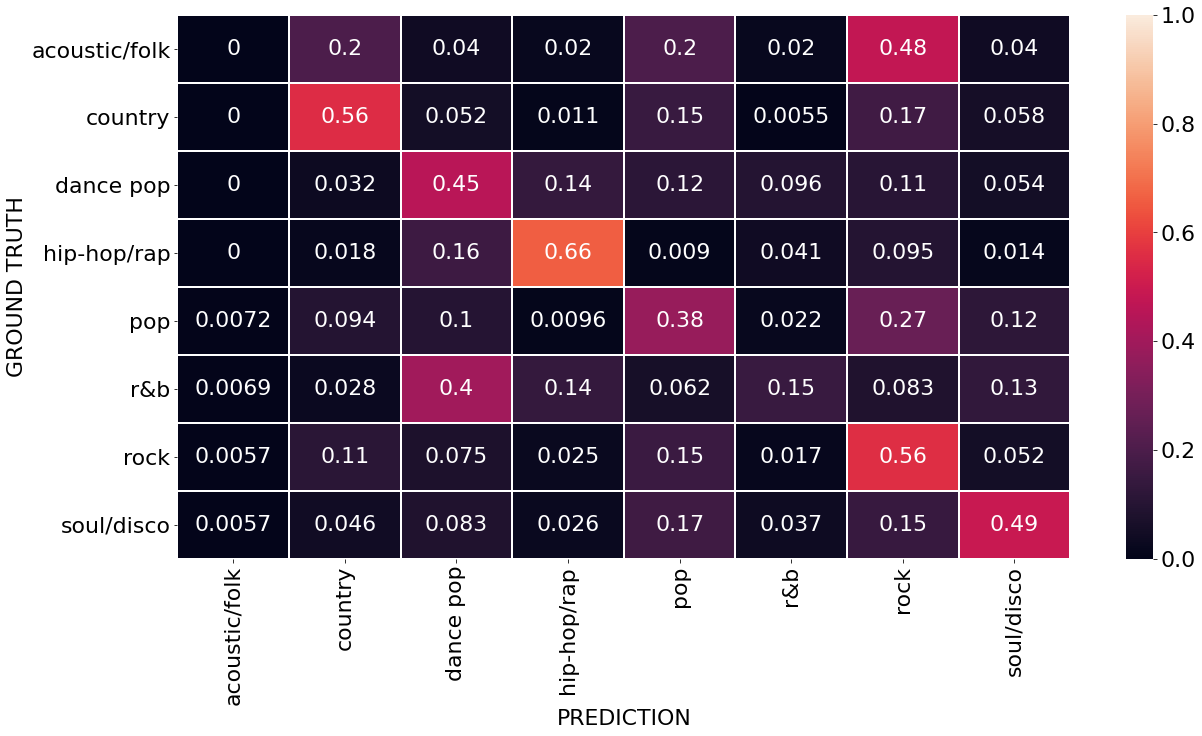

In [11]:
import matplotlib

FONTSIZE = 22
matplotlib.rc('font', size=FONTSIZE)
matplotlib.rc('axes', titlesize=FONTSIZE)

normalize = True

labels = trainer_genre.train_dataset.features["labels"]
predictions = np.argmax(h.predictions, axis=-1)
true_vals = h.label_ids
cf_matrix = confusion_matrix(true_vals, predictions, normalize="true" if normalize else None)
fig, ax = plt.subplots(figsize=(20,10)) 
if normalize:
    sns.heatmap(
        cf_matrix, 
        linewidths=1, 
        annot=True, 
        ax=ax, 
        fmt='.2g', 
        vmin=0, 
        vmax=1, 
        xticklabels=labels.names, 
        yticklabels=labels.names
    )
else:
    sns.heatmap(
        cf_matrix, linewidths=1, annot=True, ax=ax, fmt='.2g', xticklabels=labels.names, yticklabels=labels.names
    )
ax.set_ylabel("GROUND TRUTH")
ax.set_xlabel("PREDICTION");

# 3) valence

In [9]:
trainer_valence, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="sentence-transformers/all-mpnet-base-v2",
#     "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature="valence", 
    batch_size=32, 
    n_epochs=5,
    verbose=True
#     n=500
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})


Some weights of the model checkpoint at sentence-transformers/all-distilroberta-v1 were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-distilroberta-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN t

0.002
all-distilroberta-v1-finetuned-valence_frozen_base


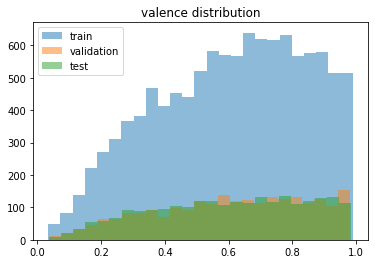

In [9]:
n_bins = 25

plt.hist(train_dataset["labels"], bins=n_bins, alpha=0.5, label="train");
plt.hist(val_dataset["labels"], bins=n_bins, alpha=0.5, label="validation");
plt.hist(test_dataset["labels"], bins=n_bins, alpha=0.5, label="test");
plt.legend()
plt.title("valence distribution");

In [10]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
# trainer_valence.train()
trainer_valence.train(resume_from_checkpoint=True)    # load previously trained

Loading model from all-mpnet-base-v2-finetuned-valence_frozen_base/checkpoint-1041).
The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 3
  Continuing training from global step 1041
  Will skip the first 3 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from all-mpnet-base-v2-finetuned-valence_frozen_base/checkpoint-694 (score: 0.048785362392663956).


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1041, training_loss=0.0, metrics={'train_runtime': 0.608, 'train_samples_per_second': 54788.611, 'train_steps_per_second': 1712.144, 'total_flos': 8764676780949504.0, 'train_loss': 0.0, 'epoch': 3.0})

In [11]:
h = trainer_valence.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


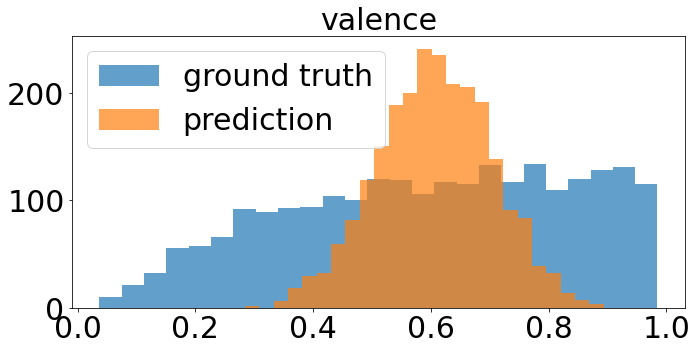

In [23]:
plt.figure(figsize=(11, 5))
plt.hist(h.label_ids, bins=25, alpha=0.7, label="ground truth")
plt.hist(h.predictions, bins=25, alpha=0.7, label="prediction")
plt.legend()
plt.title("valence");

## quantize valence for classification task

In [14]:
n_class = 2

trainer_valence_quant, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="sentence-transformers/all-mpnet-base-v2",
#     model_str="sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature="valence", 
    batch_size=32, 
    n_epochs=8,
    n_class=n_class,    # For quantization!!!
#     n=100
)

loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0349 0.625  1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

loading configuration file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/config.json from cache at /home/vidit/.cache/huggingface/transformers/713edf97a7faf69710cdf8941156f76a463a5280c7f1ae8a52981c275fcb590d.7aca2223c920d6c0c35d97cd3441414b9cd4cdddaf013b3e9ed88247815781f3
Model config MPNetConfig {
  "_name_or_path": "microsoft/mpnet-base",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.12.5",
  "vocab_size": 30527
}

loading weights file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/py

0.002
all-mpnet-base-v2-finetuned-valence_quant2_frozen_base


loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

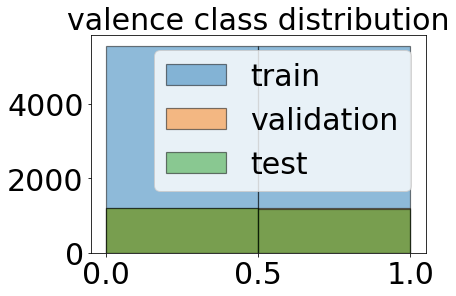

In [15]:
plt.hist(train_dataset["labels"], bins=n_class, alpha=0.5, label="train", edgecolor='black', linewidth=1.2);
plt.hist(val_dataset["labels"], bins=n_class, alpha=0.5, label="validation", edgecolor='black', linewidth=1.2);
plt.hist(test_dataset["labels"], bins=n_class, alpha=0.5, label="test", edgecolor='black', linewidth=1.2);
plt.legend()
plt.title("valence class distribution");

In [16]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
# trainer_valence_quant.train()
trainer_valence_quant.train(resume_from_checkpoint=True)    # load previously trained

Loading model from all-mpnet-base-v2-finetuned-valence_quant2_frozen_base/checkpoint-1735).
The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 8
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2776
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 1735
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy
6,0.641500,0.641701,0.621690
7,0.641500,0.640360,0.622530
8,0.638100,0.639820,0.624632


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-mpnet-base-v2-finetuned-valence_quant2_frozen_base/checkpoint-2082
Configuration saved in all-mpnet-base-v2-finetuned-valence_quant2_frozen_base/checkpoint-2082/config.json
Model weights saved in all-mpnet-base-v2-finetuned-valence_quant2_frozen_base/checkpoint-2082/pytorch_model.bin
tokenizer config file saved in all-mpnet-base-v2-finetuned-valence_quant2_frozen_base/checkpoint-2082/tokenizer_config.json
Special tokens file saved in all-mpnet-base-v2-finetuned-valence_quant2_frozen_base/checkpoint-2082/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Ba

TrainOutput(global_step=2776, training_loss=0.238734962617286, metrics={'train_runtime': 567.1821, 'train_samples_per_second': 156.62, 'train_steps_per_second': 4.894, 'total_flos': 2.337268126973952e+16, 'train_loss': 0.238734962617286, 'epoch': 8.0})

In [12]:
h = trainer_valence_quant.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


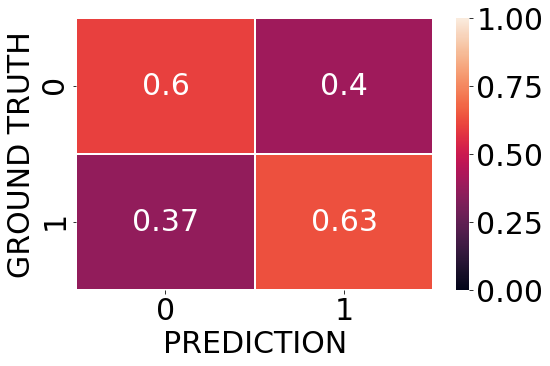

In [13]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

## finetune with base unfrozen

In [7]:
# finetune from local model
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="all-mpnet-base-v2-finetuned-valence_quant2_frozen_base/checkpoint-1735",
    lyrics=lyrics, 
    freeze_base_model=False, 
    feature="valence", 
    batch_size=32, 
    n_epochs=1,
    n_class=2,
    verbose=True
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0349 0.625  1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

In [9]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
# trainer.train()
trainer.train("all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347")
# trainer.train(resume_from_checkpoint=True)    # load previously trained

Loading model from all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347).
The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 347
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 347
  Will skip the first 1 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from all-mpnet-base-v2-finetuned-valence_quant2_unfrozen_base-checkpoint-1735/checkpoint-347 (score: 0.6569987389659521).


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=347, training_loss=0.0, metrics={'train_runtime': 0.8913, 'train_samples_per_second': 12458.644, 'train_steps_per_second': 389.333, 'total_flos': 2921585158717440.0, 'train_loss': 0.0, 'epoch': 1.0})

In [10]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


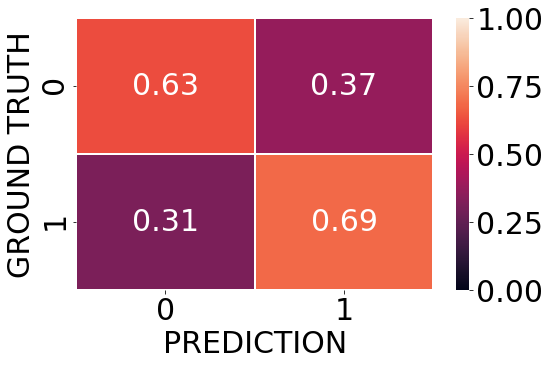

In [11]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

# 4) liveness

An feature that shouldn't work well since it's a very acoustic feature. But also skewed.

In [12]:
n_class = 2
feature = "liveness"

trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="sentence-transformers/all-mpnet-base-v2",
#     "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature=feature, 
    batch_size=32, 
    n_epochs=3,
    n_class=n_class,    # For quantization!!!
)

loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0136 0.13   1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

loading configuration file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/config.json from cache at /home/vidit/.cache/huggingface/transformers/713edf97a7faf69710cdf8941156f76a463a5280c7f1ae8a52981c275fcb590d.7aca2223c920d6c0c35d97cd3441414b9cd4cdddaf013b3e9ed88247815781f3
Model config MPNetConfig {
  "_name_or_path": "microsoft/mpnet-base",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.12.5",
  "vocab_size": 30527
}

loading weights file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/py

0.002
all-mpnet-base-v2-finetuned-liveness_quant2_frozen_base


loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

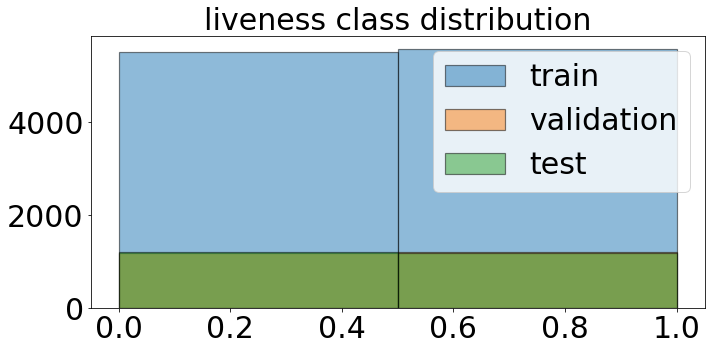

In [13]:
plt.figure(figsize=(11, 5))
plt.hist(train_dataset["labels"], bins=n_class, alpha=0.5, label="train", edgecolor='black', linewidth=1.2);
plt.hist(val_dataset["labels"], bins=n_class, alpha=0.5, label="validation", edgecolor='black', linewidth=1.2);
plt.hist(test_dataset["labels"], bins=n_class, alpha=0.5, label="test", edgecolor='black', linewidth=1.2);
plt.legend()
plt.title(f"{feature} class distribution");

In [14]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer.train()
# trainer.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.696077,0.507356
2,0.698700,0.695344,0.521648
3,0.691200,0.693870,0.526692


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-mpnet-base-v2-finetuned-liveness_quant2_frozen_base/checkpoint-347
Configuration saved in all-mpnet-base-v2-finetuned-liveness_quant2_frozen_base/checkpoint-347/config.json
Model weights saved in all-mpnet-base-v2-finetuned-liveness_quant2_frozen_base/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-mpnet-base-v2-finetuned-liveness_quant2_frozen_base/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-mpnet-base-v2-finetuned-liveness_quant2_frozen_base/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Ba

TrainOutput(global_step=1041, training_loss=0.6947483388880602, metrics={'train_runtime': 581.5268, 'train_samples_per_second': 57.284, 'train_steps_per_second': 1.79, 'total_flos': 8764755476152320.0, 'train_loss': 0.6947483388880602, 'epoch': 3.0})

In [15]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


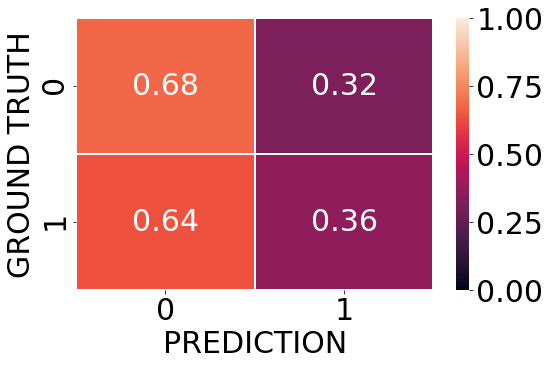

In [17]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

# 5) danceability

In [18]:
feature = "danceability"

trainer_dance, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="sentence-transformers/all-mpnet-base-v2",
#     "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature=feature, 
    batch_size=32, 
    n_epochs=3,
    verbose=True
#     n=500
)

loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})


loading configuration file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/config.json from cache at /home/vidit/.cache/huggingface/transformers/713edf97a7faf69710cdf8941156f76a463a5280c7f1ae8a52981c275fcb590d.7aca2223c920d6c0c35d97cd3441414b9cd4cdddaf013b3e9ed88247815781f3
Model config MPNetConfig {
  "_name_or_path": "microsoft/mpnet-base",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.12.5",
  "vocab_size": 30527
}

loading weights file 

0.002
all-mpnet-base-v2-finetuned-danceability_frozen_base


HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/models/sentence-transformers/all-mpnet-base-v2

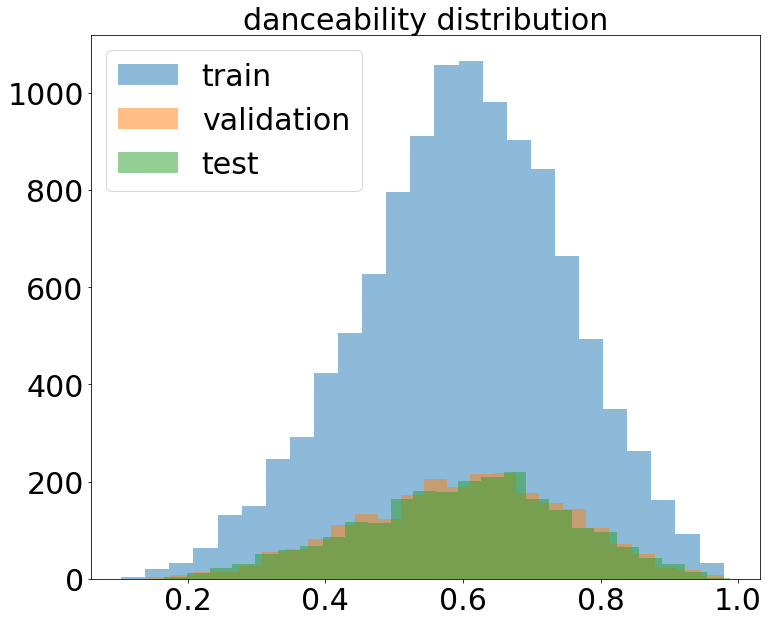

In [47]:
n_bins = 25

plt.figure(figsize=(12, 5))
plt.hist(train_dataset["labels"], bins=n_bins, alpha=0.5, label="train");
plt.hist(val_dataset["labels"], bins=n_bins, alpha=0.5, label="validation");
plt.hist(test_dataset["labels"], bins=n_bins, alpha=0.5, label="test");
plt.legend()
plt.title(f"{feature} distribution");

In [48]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer_dance.train()
# trainer_dance.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041


Epoch,Training Loss,Validation Loss
1,No log,0.019049
2,0.024100,0.018320
3,0.020000,0.018086


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-mpnet-base-v2-finetuned-danceability_frozen_base/checkpoint-347
Configuration saved in all-mpnet-base-v2-finetuned-danceability_frozen_base/checkpoint-347/config.json
Model weights saved in all-mpnet-base-v2-finetuned-danceability_frozen_base/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-mpnet-base-v2-finetuned-danceability_frozen_base/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-mpnet-base-v2-finetuned-danceability_frozen_base/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
S

TrainOutput(global_step=1041, training_loss=0.02185966290612271, metrics={'train_runtime': 511.1804, 'train_samples_per_second': 65.167, 'train_steps_per_second': 2.036, 'total_flos': 8764676780949504.0, 'train_loss': 0.02185966290612271, 'epoch': 3.0})

In [49]:
h = trainer_dance.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


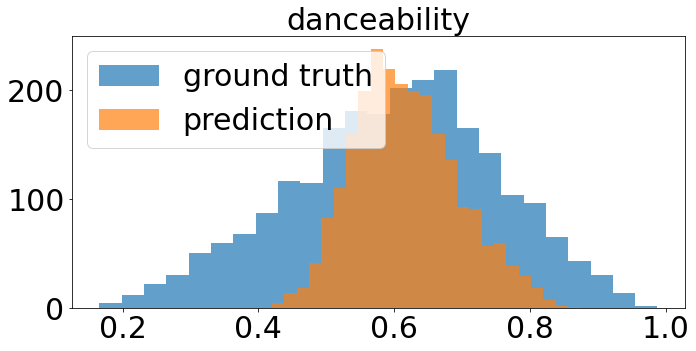

In [50]:
plt.figure(figsize=(11, 5))
plt.hist(h.label_ids, bins=25, alpha=0.7, label="ground truth")
plt.hist(h.predictions, bins=25, alpha=0.7, label="prediction")
plt.legend()
plt.title(f"{feature}");

### quantize danceability for classification task

In [7]:
n_class = 2
feature = "danceability"

trainer_dance_quant, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="sentence-transformers/all-mpnet-base-v2",
#     "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature=feature, 
    batch_size=32, 
    n_epochs=5,
#     learning_rate=1e-3,
    n_class=n_class    # For quantization!!!
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.103 0.603 1.   ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 

Some weights of the model checkpoint at sentence-transformers/all-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a

0.002
all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base


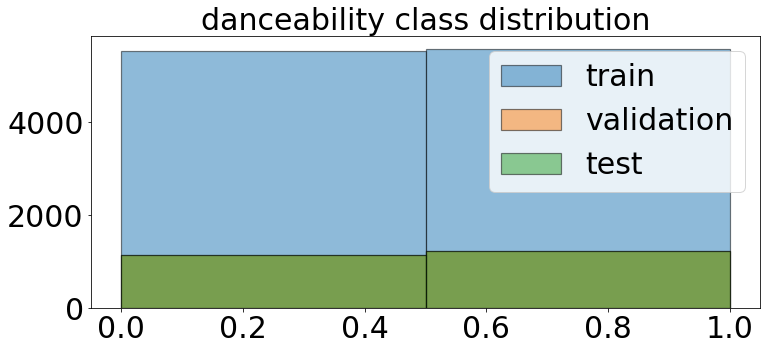

In [8]:
plt.figure(figsize=(12, 5))
plt.hist(train_dataset["labels"], bins=n_class, alpha=0.5, label="train", edgecolor='black', linewidth=1.2);
plt.hist(val_dataset["labels"], bins=n_class, alpha=0.5, label="validation", edgecolor='black', linewidth=1.2);
plt.hist(test_dataset["labels"], bins=n_class, alpha=0.5, label="test", edgecolor='black', linewidth=1.2);
plt.legend()
plt.title(f"{feature} class distribution");

In [9]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
# trainer_dance_quant.train()
trainer_dance_quant.train("all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735")
# trainer_dance_quant.train(resume_from_checkpoint=True)    # load previously trained

Loading model from all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735).
The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 1735
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735 (score: 0.6536359815048339).


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1735, training_loss=0.0, metrics={'train_runtime': 0.6269, 'train_samples_per_second': 88569.141, 'train_steps_per_second': 2767.786, 'total_flos': 1.46079257935872e+16, 'train_loss': 0.0, 'epoch': 5.0})

In [10]:
h = trainer_dance_quant.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


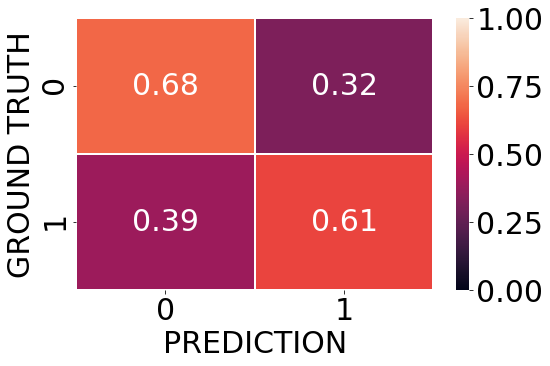

In [11]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

## finetune with base unfrozen

In [22]:
# finetune from local model
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735",
    lyrics=lyrics, 
    freeze_base_model=False, 
    feature="danceability", 
    batch_size=32, 
#     n_epochs=5,
    n_epochs=2,
    n_class=2,
    learning_rate=2e-6,
    verbose=True
)

Didn't find file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/added_tokens.json. We won't load it.
loading file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/vocab.txt
loading file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/tokenizer.json
loading file None
loading file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/special_tokens_map.json
loading file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/tokenizer_config.json


  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

loading configuration file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/config.json
Model config MPNetConfig {
  "_name_or_path": "sentence-transformers/all-mpnet-base-v2",
  "architectures": [
    "MPNetForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "vocab_size": 30527
}

loading weights file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/pytorch_model.bin


tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.103 0.603 1.   ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 

All model checkpoint weights were used when initializing MPNetForSequenceClassification.

All the weights of MPNetForSequenceClassification were initialized from the model checkpoint at all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735.
If your task is similar to the task the model of the checkpoint was trained on, you can already use MPNetForSequenceClassification for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


2e-06
all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735


Didn't find file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/added_tokens.json. We won't load it.
loading file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/vocab.txt
loading file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/tokenizer.json
loading file None
loading file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/special_tokens_map.json
loading file all-mpnet-base-v2-finetuned-danceability_quant2_frozen_base/checkpoint-1735/tokenizer_config.json


In [19]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer.train()
# trainer.train("all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-347")
# trainer.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 694


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.609689,0.656158
2,0.599800,0.607080,0.666667


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-347
Configuration saved in all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-347/config.json
Model weights saved in all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequence

TrainOutput(global_step=694, training_loss=0.5970615200075705, metrics={'train_runtime': 881.6275, 'train_samples_per_second': 25.19, 'train_steps_per_second': 0.787, 'total_flos': 5843170317434880.0, 'train_loss': 0.5970615200075705, 'epoch': 2.0})

In [20]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


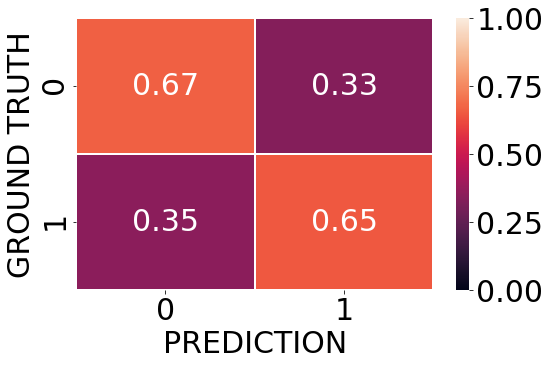

In [21]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

# 6) energy

In [25]:
feature = "energy"

trainer_energy, train_dataset, val_dataset, test_dataset = create_trainer(
#     model_str="sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature=feature, 
    batch_size=32, 
    n_epochs=3,
    verbose=True
#     n=500
)

loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/vocab.json from cache at /home/vidit/.cache/huggingface/transformers/15fcc099555b0abaa25ff13f01483e8db97554714456c1d7649dd88ab37d7edc.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/merges.txt from cache at /home/vidit/.cache/huggingface/transformers/e9cc246bd8d4dbfcfe8edfe20a5c4cd1e8d8e9e7fd611aa29c0a9b7946766bb0.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/a36735209cde2a30e700649f2b0420a5436b93e52a1c61a7f70fdc037235ce91.7174855fa60dccd2d05f9fbc95fd98d03004f64593566425e38a028aa9125ca2
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/added_tokens.json from cache at

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})


loading configuration file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/config.json from cache at /home/vidit/.cache/huggingface/transformers/afe29b63b408ab70e7c8b046f341b1e4a8c250479eba36cb7a533a639a419adb.c0623772409bc26004b4eabfb4b777c32a918d072f9168ac77fd00be62a3b614
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transfo

0.002
all-distilroberta-v1-finetuned-energy_frozen_base


loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/vocab.json from cache at /home/vidit/.cache/huggingface/transformers/15fcc099555b0abaa25ff13f01483e8db97554714456c1d7649dd88ab37d7edc.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/merges.txt from cache at /home/vidit/.cache/huggingface/transformers/e9cc246bd8d4dbfcfe8edfe20a5c4cd1e8d8e9e7fd611aa29c0a9b7946766bb0.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/a36735209cde2a30e700649f2b0420a5436b93e52a1c61a7f70fdc037235ce91.7174855fa60dccd2d05f9fbc95fd98d03004f64593566425e38a028aa9125ca2
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/added_tokens.json from cache at

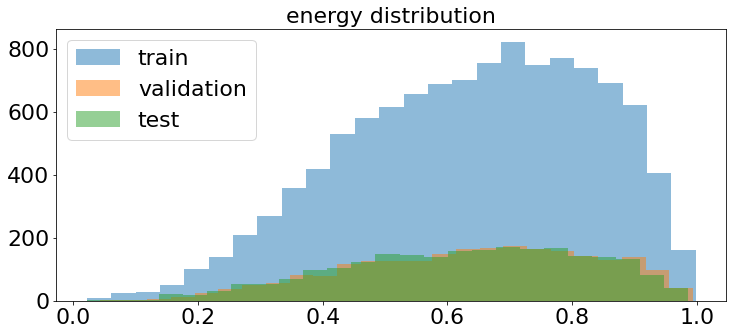

In [26]:
n_bins = 25

plt.figure(figsize=(12, 5))
plt.hist(train_dataset["labels"], bins=n_bins, alpha=0.5, label="train");
plt.hist(val_dataset["labels"], bins=n_bins, alpha=0.5, label="validation");
plt.hist(test_dataset["labels"], bins=n_bins, alpha=0.5, label="test");
plt.legend()
plt.title(f"{feature} distribution");

In [27]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer_energy.train()
# trainer_energy.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041


Epoch,Training Loss,Validation Loss
1,No log,0.033792
2,0.136100,0.032921
3,0.035400,0.030766


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-distilroberta-v1-finetuned-energy_frozen_base/checkpoint-347
Configuration saved in all-distilroberta-v1-finetuned-energy_frozen_base/checkpoint-347/config.json
Model weights saved in all-distilroberta-v1-finetuned-energy_frozen_base/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-distilroberta-v1-finetuned-energy_frozen_base/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-distilroberta-v1-finetuned-energy_frozen_base/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model

TrainOutput(global_step=1041, training_loss=0.0836408939874596, metrics={'train_runtime': 245.2076, 'train_samples_per_second': 135.852, 'train_steps_per_second': 4.245, 'total_flos': 4412675288825856.0, 'train_loss': 0.0836408939874596, 'epoch': 3.0})

In [28]:
h = trainer_energy.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


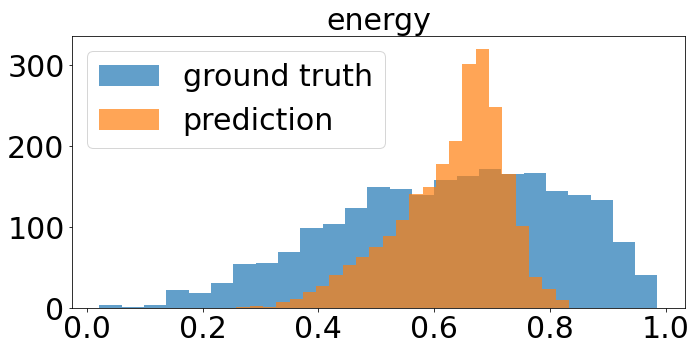

In [29]:
import matplotlib

FONTSIZE = 30
matplotlib.rc('font', size=FONTSIZE)
matplotlib.rc('axes', titlesize=FONTSIZE)

plt.figure(figsize=(11, 5))
plt.hist(h.label_ids, bins=25, alpha=0.7, label="ground truth")
plt.hist(h.predictions, bins=25, alpha=0.7, label="prediction")
plt.legend()
plt.title(f"{feature}");

### quantize energy for classification task

In [24]:
n_class = 2

trainer_energy_quant, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="sentence-transformers/all-mpnet-base-v2",
#     "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature="energy", 
    batch_size=32, 
    n_epochs=5,
#     learning_rate=1e-3,
    n_class=n_class    # For quantization!!!
)

loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0223 0.656  1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

loading configuration file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/config.json from cache at /home/vidit/.cache/huggingface/transformers/713edf97a7faf69710cdf8941156f76a463a5280c7f1ae8a52981c275fcb590d.7aca2223c920d6c0c35d97cd3441414b9cd4cdddaf013b3e9ed88247815781f3
Model config MPNetConfig {
  "_name_or_path": "microsoft/mpnet-base",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.12.5",
  "vocab_size": 30527
}

loading weights file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/py

0.002
all-mpnet-base-v2-finetuned-energy_quant2_frozen_base


loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/vocab.txt from cache at /home/vidit/.cache/huggingface/transformers/8315d683fe4a42d6fd81ce1c62f8bcb86c0c5df05d492050ad7d4c061d3f73ff.98b26f9c960899aa0e99c10a12750104e467743b3b460b79fa7d76907549319b
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/79abcaf3dc31b24be4f194aae8ec6f9cc23c35af9bbad48d1a607ec53f71883f.89908b4b885d20787abb7eb8457041d3bf78239e7af3dd84ff3bb91e8018ab54
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/special_tokens_map.json from cache at /home/vidit/.cache/huggingface/transformers/5a35eead90431b7f9cf87a56eb63db14171d34133757a98b5bdd0a9c8049adb0.18ebceb237d999d8f1cb15935e35b314f3e73dd6c4f65e119f4790fa226

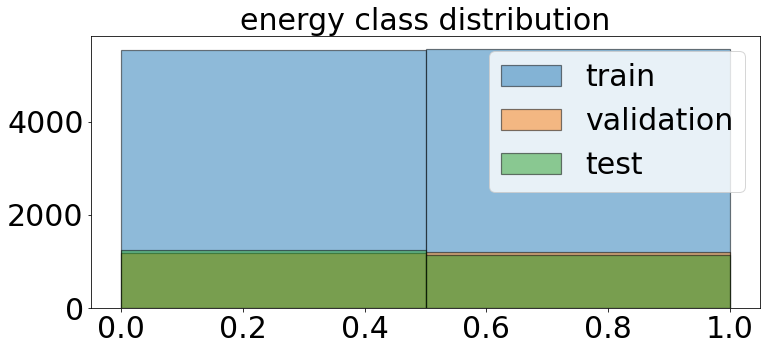

In [31]:
plt.figure(figsize=(12, 5))
plt.hist(train_dataset["labels"], bins=n_class, alpha=0.5, label="train", edgecolor='black', linewidth=1.2);
plt.hist(val_dataset["labels"], bins=n_class, alpha=0.5, label="validation", edgecolor='black', linewidth=1.2);
plt.hist(test_dataset["labels"], bins=n_class, alpha=0.5, label="test", edgecolor='black', linewidth=1.2);
plt.legend()
plt.title(f"{feature} class distribution");

In [25]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer_energy_quant.train()
# trainer_energy_quant.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.651489,0.624212
2,0.666300,0.659223,0.604456
3,0.649500,0.649065,0.617066
4,0.649500,0.650288,0.630517
5,0.642100,0.648444,0.627995


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-mpnet-base-v2-finetuned-energy_quant2_frozen_base/checkpoint-347
Configuration saved in all-mpnet-base-v2-finetuned-energy_quant2_frozen_base/checkpoint-347/config.json
Model weights saved in all-mpnet-base-v2-finetuned-energy_quant2_frozen_base/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-mpnet-base-v2-finetuned-energy_quant2_frozen_base/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-mpnet-base-v2-finetuned-energy_quant2_frozen_base/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size =

TrainOutput(global_step=1735, training_loss=0.65072252784751, metrics={'train_runtime': 906.0548, 'train_samples_per_second': 61.277, 'train_steps_per_second': 1.915, 'total_flos': 1.46079257935872e+16, 'train_loss': 0.65072252784751, 'epoch': 5.0})

In [26]:
h = trainer_energy_quant.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


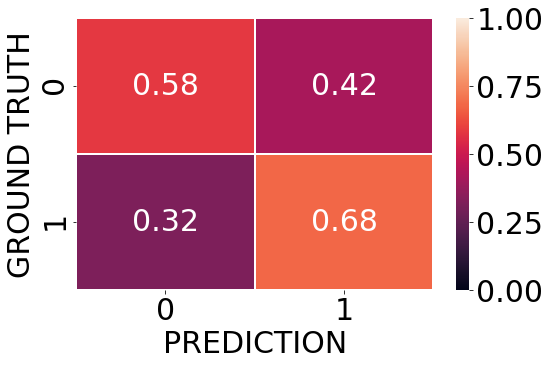

In [27]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

## finetune with base unfrozen

In [7]:
# finetune from local model
trainer, train_dataset, val_dataset, test_dataset = create_trainer(
    model_str="all-mpnet-base-v2-finetuned-energy_quant2_frozen_base/checkpoint-1388",
    lyrics=lyrics, 
    freeze_base_model=False, 
    feature="energy", 
    batch_size=32, 
#     n_epochs=5,
    n_epochs=4,
    n_class=2,
    learning_rate=2e-6,
    verbose=True
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[0.0223 0.656  1.    ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_row

In [ ]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer.train()
# trainer.train("all-mpnet-base-v2-finetuned-danceability_quant2_unfrozen_base-checkpoint-1735/checkpoint-347")
# trainer.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.633472,0.642287
2,0.620400,0.629746,0.646070
3,0.596200,0.631895,0.647751
4,0.596200,0.632137,0.653636
5,0.588200,0.632620,0.652795


The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-347
Configuration saved in all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-347/config.json
Model weights saved in all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and ha

In [8]:
trainer.train("all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388")

Loading model from all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388).
The following columns in the training set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1388
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 1388
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from all-mpnet-base-v2-finetuned-energy_quant2_unfrozen_base-checkpoint-1388/checkpoint-1388 (score: 0.6536359815048339).


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1388, training_loss=0.0, metrics={'train_runtime': 1.561, 'train_samples_per_second': 28453.627, 'train_steps_per_second': 889.176, 'total_flos': 1.168634063486976e+16, 'train_loss': 0.0, 'epoch': 4.0})

In [9]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `MPNetForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


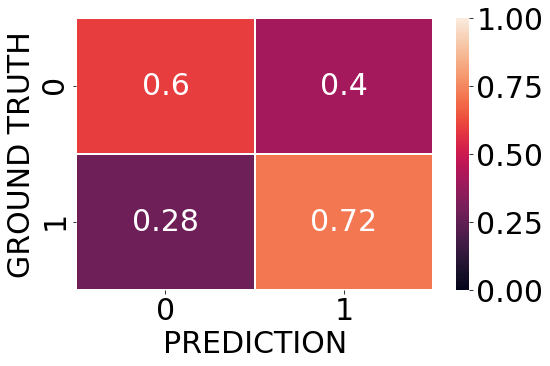

In [10]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

# 7) tempo

An feature that shouldn't work well since it's a very acoustic feature.

In [10]:
n_class = 2
feature = "tempo"

trainer, train_dataset, val_dataset, test_dataset = create_trainer(
#     model_str="sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature=feature, 
    batch_size=32, 
    n_epochs=3,
    n_class=n_class,    # For quantization!!!
    max_val=232
)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[ 37.114 119.252 232.   ]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_

Some weights of the model checkpoint at sentence-transformers/all-distilroberta-v1 were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-distilroberta-v1 and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN t

0.002
all-distilroberta-v1-finetuned-tempo_quant2_frozen_base


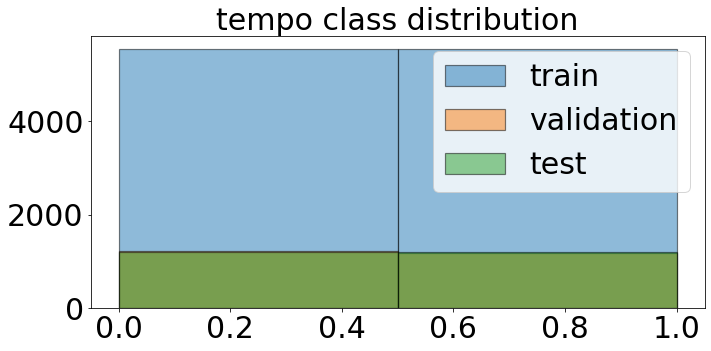

In [11]:
plt.figure(figsize=(11, 5))
plt.hist(train_dataset["labels"], bins=n_class, alpha=0.5, label="train", edgecolor='black', linewidth=1.2);
plt.hist(val_dataset["labels"], bins=n_class, alpha=0.5, label="validation", edgecolor='black', linewidth=1.2);
plt.hist(test_dataset["labels"], bins=n_class, alpha=0.5, label="test", edgecolor='black', linewidth=1.2);
plt.legend()
plt.title(f"{feature} class distribution");

In [12]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer.train()
# trainer.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.730338,0.508617
2,0.726600,0.689412,0.537201
3,0.700900,0.690851,0.530475


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-distilroberta-v1-finetuned-tempo_quant2_frozen_base/checkpoint-347
Configuration saved in all-distilroberta-v1-finetuned-tempo_quant2_frozen_base/checkpoint-347/config.json
Model weights saved in all-distilroberta-v1-finetuned-tempo_quant2_frozen_base/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-distilroberta-v1-finetuned-tempo_quant2_frozen_base/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-distilroberta-v1-finetuned-tempo_quant2_frozen_base/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379


TrainOutput(global_step=1041, training_loss=0.7127942223599275, metrics={'train_runtime': 254.8559, 'train_samples_per_second': 130.709, 'train_steps_per_second': 4.085, 'total_flos': 4412753984028672.0, 'train_loss': 0.7127942223599275, 'epoch': 3.0})

In [13]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


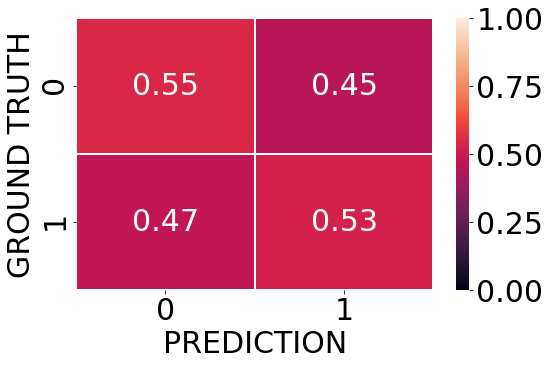

In [14]:
normalize = True

predictions = np.argmax(h.predictions, axis=-1)
true_vals = h.label_ids
cf_matrix = confusion_matrix(true_vals, predictions, normalize="true" if normalize else None)
fig, ax = plt.subplots(figsize=(8, 5)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='.2g', vmin=0, vmax=1);
ax.set_ylabel("GROUND TRUTH")
ax.set_xlabel("PREDICTION");

# 8) song popularity

An feature that shouldn't work well.

In [37]:
n_class = 2
feature = "song_popularity"

# del trainer

trainer, train_dataset, val_dataset, test_dataset = create_trainer(
#     model_str="sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature=feature, 
    batch_size=32, 
    n_epochs=5,
    n_class=n_class,    # For quantization!!!
    max_val=100
)

loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/vocab.json from cache at /home/vidit/.cache/huggingface/transformers/15fcc099555b0abaa25ff13f01483e8db97554714456c1d7649dd88ab37d7edc.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/merges.txt from cache at /home/vidit/.cache/huggingface/transformers/e9cc246bd8d4dbfcfe8edfe20a5c4cd1e8d8e9e7fd611aa29c0a9b7946766bb0.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/a36735209cde2a30e700649f2b0420a5436b93e52a1c61a7f70fdc037235ce91.7174855fa60dccd2d05f9fbc95fd98d03004f64593566425e38a028aa9125ca2
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/added_tokens.json from cache at

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[  0.  40. 100.]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 238

loading configuration file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/config.json from cache at /home/vidit/.cache/huggingface/transformers/afe29b63b408ab70e7c8b046f341b1e4a8c250479eba36cb7a533a639a419adb.c0623772409bc26004b4eabfb4b777c32a918d072f9168ac77fd00be62a3b614
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 1,
  "use_cache": true,
  "voca

0.002
all-distilroberta-v1-finetuned-song_popularity_quant2_frozen_base


loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/vocab.json from cache at /home/vidit/.cache/huggingface/transformers/15fcc099555b0abaa25ff13f01483e8db97554714456c1d7649dd88ab37d7edc.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/merges.txt from cache at /home/vidit/.cache/huggingface/transformers/e9cc246bd8d4dbfcfe8edfe20a5c4cd1e8d8e9e7fd611aa29c0a9b7946766bb0.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/a36735209cde2a30e700649f2b0420a5436b93e52a1c61a7f70fdc037235ce91.7174855fa60dccd2d05f9fbc95fd98d03004f64593566425e38a028aa9125ca2
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/added_tokens.json from cache at

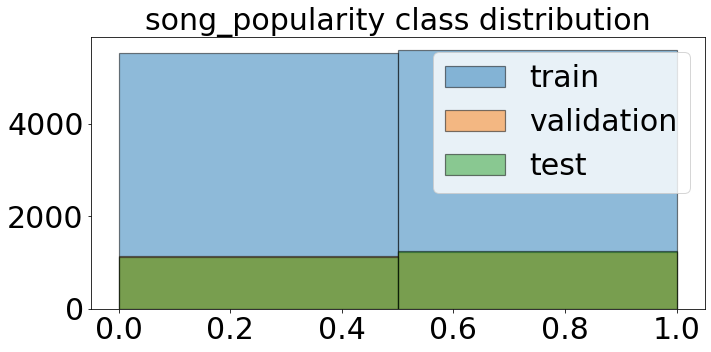

In [38]:
plt.figure(figsize=(11, 5))
plt.hist(train_dataset["labels"], bins=n_class, alpha=0.5, label="train", edgecolor='black', linewidth=1.2);
plt.hist(val_dataset["labels"], bins=n_class, alpha=0.5, label="validation", edgecolor='black', linewidth=1.2);
plt.hist(test_dataset["labels"], bins=n_class, alpha=0.5, label="test", edgecolor='black', linewidth=1.2);
plt.legend()
plt.title(f"{feature} class distribution");

In [ ]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer.train()
# trainer.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1735


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.673067,0.593527
2,0.695300,0.646816,0.622951


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-distilroberta-v1-finetuned-song_popularity_quant2_frozen_base/checkpoint-347
Configuration saved in all-distilroberta-v1-finetuned-song_popularity_quant2_frozen_base/checkpoint-347/config.json
Model weights saved in all-distilroberta-v1-finetuned-song_popularity_quant2_frozen_base/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-distilroberta-v1-finetuned-song_popularity_quant2_frozen_base/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-distilroberta-v1-finetuned-song_popularity_quant2_frozen_base/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***

In [ ]:
h = trainer.predict(test_dataset)

In [ ]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

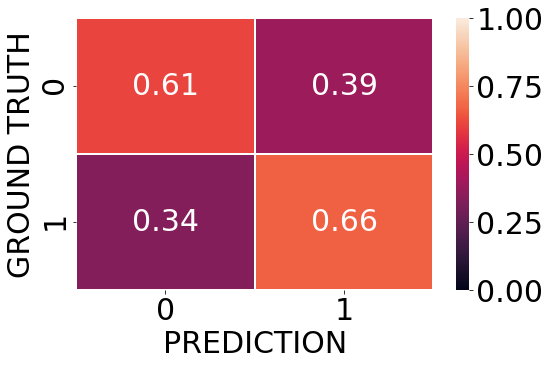

In [19]:
plot_confusion(predictions=np.argmax(h.predictions, axis=-1), true_vals=h.label_ids, normalize=True)

# 9) Release year

An feature that shouldn't work well.

In [20]:
n_class = 2
feature = "release_year"

del trainer

trainer, train_dataset, val_dataset, test_dataset = create_trainer(
#     model_str="sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    lyrics=lyrics, 
    freeze_base_model=True, 
    feature=feature, 
    batch_size=32, 
    n_epochs=3,
    n_class=n_class,    # For quantization!!!
    max_val=2022
)

loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/vocab.json from cache at /home/vidit/.cache/huggingface/transformers/15fcc099555b0abaa25ff13f01483e8db97554714456c1d7649dd88ab37d7edc.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/merges.txt from cache at /home/vidit/.cache/huggingface/transformers/e9cc246bd8d4dbfcfe8edfe20a5c4cd1e8d8e9e7fd611aa29c0a9b7946766bb0.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/a36735209cde2a30e700649f2b0420a5436b93e52a1c61a7f70fdc037235ce91.7174855fa60dccd2d05f9fbc95fd98d03004f64593566425e38a028aa9125ca2
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/added_tokens.json from cache at

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

tokenized lyrics DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'text'],
        num_rows: 2380
    })
})
[1947. 1999. 2022.]
{'train': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
}), 'validation': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
}), 'test': Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2380
})}
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 11104
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 2379
})
Dataset({
    features: ['attention_mask', 'input_ids', 'text', 'labels'],
    num_rows: 

loading configuration file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/config.json from cache at /home/vidit/.cache/huggingface/transformers/afe29b63b408ab70e7c8b046f341b1e4a8c250479eba36cb7a533a639a419adb.c0623772409bc26004b4eabfb4b777c32a918d072f9168ac77fd00be62a3b614
Model config RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 1,
  "use_cache": true,
  "voca

0.002
all-distilroberta-v1-finetuned-release_year_quant2_frozen_base


loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/vocab.json from cache at /home/vidit/.cache/huggingface/transformers/15fcc099555b0abaa25ff13f01483e8db97554714456c1d7649dd88ab37d7edc.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/merges.txt from cache at /home/vidit/.cache/huggingface/transformers/e9cc246bd8d4dbfcfe8edfe20a5c4cd1e8d8e9e7fd611aa29c0a9b7946766bb0.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/tokenizer.json from cache at /home/vidit/.cache/huggingface/transformers/a36735209cde2a30e700649f2b0420a5436b93e52a1c61a7f70fdc037235ce91.7174855fa60dccd2d05f9fbc95fd98d03004f64593566425e38a028aa9125ca2
loading file https://huggingface.co/sentence-transformers/all-distilroberta-v1/resolve/main/added_tokens.json from cache at

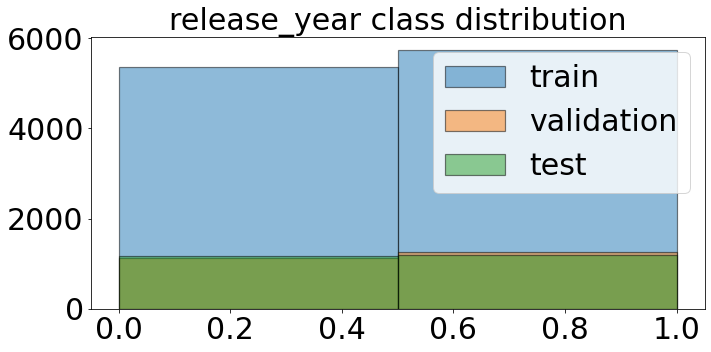

In [21]:
plt.figure(figsize=(11, 5))
plt.hist(train_dataset["labels"], bins=n_class, alpha=0.5, label="train", edgecolor='black', linewidth=1.2);
plt.hist(val_dataset["labels"], bins=n_class, alpha=0.5, label="validation", edgecolor='black', linewidth=1.2);
plt.hist(test_dataset["labels"], bins=n_class, alpha=0.5, label="test", edgecolor='black', linewidth=1.2);
plt.legend()
plt.title(f"{feature} class distribution");

In [22]:
# debugging: https://huggingface.co/course/chapter8/4?fw=pt
trainer.train()
# trainer.train(resume_from_checkpoint=True)    # load previously trained

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 11104
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1041


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.735862,0.556536
2,0.683800,0.652986,0.619168
3,0.645300,0.627662,0.639344


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2379
  Batch size = 32
Saving model checkpoint to all-distilroberta-v1-finetuned-release_year_quant2_frozen_base/checkpoint-347
Configuration saved in all-distilroberta-v1-finetuned-release_year_quant2_frozen_base/checkpoint-347/config.json
Model weights saved in all-distilroberta-v1-finetuned-release_year_quant2_frozen_base/checkpoint-347/pytorch_model.bin
tokenizer config file saved in all-distilroberta-v1-finetuned-release_year_quant2_frozen_base/checkpoint-347/tokenizer_config.json
Special tokens file saved in all-distilroberta-v1-finetuned-release_year_quant2_frozen_base/checkpoint-347/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Eval

TrainOutput(global_step=1041, training_loss=0.6635790741523794, metrics={'train_runtime': 242.6097, 'train_samples_per_second': 137.307, 'train_steps_per_second': 4.291, 'total_flos': 4412753984028672.0, 'train_loss': 0.6635790741523794, 'epoch': 3.0})

In [23]:
h = trainer.predict(test_dataset)

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2380
  Batch size = 32


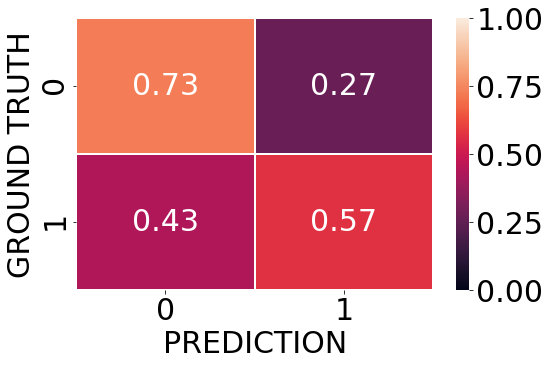

In [24]:
normalize = True

predictions = np.argmax(h.predictions, axis=-1)
true_vals = h.label_ids
cf_matrix = confusion_matrix(true_vals, predictions, normalize="true" if normalize else None)
fig, ax = plt.subplots(figsize=(8, 5)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='.2g', vmin=0, vmax=1);
ax.set_ylabel("GROUND TRUTH")
ax.set_xlabel("PREDICTION");